# Layer Cake Example

#### In this example we will see basic functionality of the `KirchMig.jl` package, including standard and least-squares Kirchhoff migration demigration.

### 0. Load modules

In [1]:
#using Distributed
#addprocs(Sys.CPU_THREADS)

import PyPlot; const plt = PyPlot

import KirchMig

### 1. Create reflection data

First step is to create a reflection data, which we will use to demonstrate Kirchhoff demigration. Later, we will use this data for migration.

In [2]:
dz, dx = 15, 15
x = 0:dx:1000; nx = length(x)
z = 0:dz:1000; nz = length(z)

rho = 1000ones(nz, nx)
rho[div(330,dx):end,:] .+= 1000
rho[div(670,dz):end,:] .-= 500

vel = 2000 .+ zero(rho)

imp = 1e-3rho.*vel;

refl = [zeros(nx)'
    (imp[2:end,:] .- imp[1:end-1,:])./(imp[2:end,:] .+ imp[1:end-1,:])]

refl[div(nz, 2)-1, div(nx, 2)] += 0.2
refl[div(nz, 2)+1, div(nx, 2)] += 0.2;

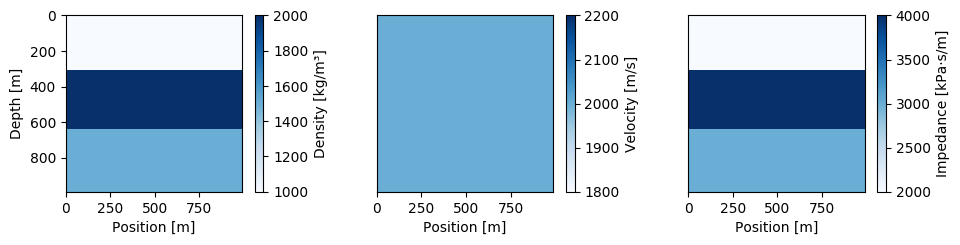

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(10,2.5))

# Density
cax = ax[1].imshow(rho, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues", interpolation=nothing)
ax[1].set(xlabel="Position [m]", ylabel="Depth [m]")
cbar = fig.colorbar(cax, ax=ax[1])
cbar.ax.set(ylabel="Density [kg/m³]")

# Velocity
cax = ax[2].imshow(vel, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues", interpolation=nothing)
ax[2].set(xlabel="Position [m]", yticks=[])
cbar = fig.colorbar(cax, ax=ax[2])
cbar.ax.set(ylabel="Velocity [m/s]");

cax = ax[3].imshow(imp, extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Blues", interpolation=nothing)
ax[3].set(xlabel="Position [m]", yticks=[])
cbar = fig.colorbar(cax, ax=ax[3])
cbar.ax.set(ylabel="Impedance [kPa·s/m]");
fig.tight_layout()

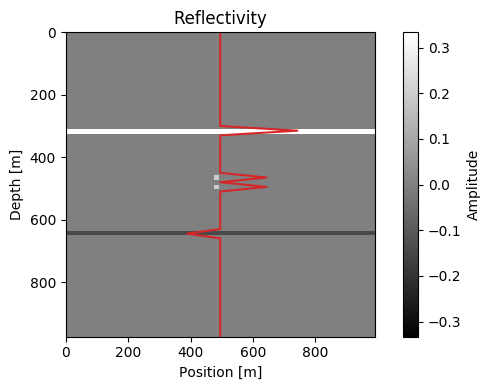

In [4]:
xran = x[end]-x[1]
mod = reshape(refl, nz, nx)
vmin, vmax = maximum(abs.(mod))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax.imshow(mod, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
cbar = fig.colorbar(cax, ax=ax)
cbar.ax.set(ylabel="Amplitude");
ax.plot(xran*mod[:,div(end,2)]./(4vmax) .+ xran./2, z, color="#d62728");
ax.set(xlim=(x[1], x[end]), ylim=(z[end-1], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="Reflectivity")
fig.tight_layout()

### 2. Create traveltime tables

The Kirchhoff modeling (or, more accurately, demigration) and migration operators require source/receiver traveltime tables. That is, they require one to know traveltimes from each source/receiver to each model point. In the case of a constant velocity, this can be easily calculated with the this formula:

$$ trav(z, x; z_{S/R}, x_{S/R}) = \frac{\sqrt{(z-z_{S/R})^2 + (x-x_{S/R})^2)}}{v}$$

where $(z, x)$ are the coordinates of subsurface point, $(z_{S/R}, x_{S/R})$ are the coordinates of the source/receiver and $v$ is the velocity.

This calculated is implemented in `eikonal_const_vel`, whose first argument takes an `AbstractMatrix` whose first column contains $z$ coordinates of all sources (or receivers), $z_{S/R,1}, \ldots z_{S/R,n}$; the second column contains $x$ coordinates of these same sources $x_{S/R,1}, \ldots x_{S/R,n}$, and so on until all spatial dimensions are accounted for. Its second and third arguments take `AbstractVector`s representing, respectively, $z$ and $x$ subsurface locations. In 3D, the fourth argument are the subsurface $y$ locations. The last argument is the velocity.

For now, we will use coinciding sources/receivers, so we will only calculate one traveltime table. When sources and receivers are in different positions, two separate traveltime tables must be computed.

In [5]:
ns = 50

src_z = zeros(ns)
src_x = 0:20:(ns-1)*20

trav = KirchMig.eikonal_const_vel([src_z src_x], z, x, vel[1]);

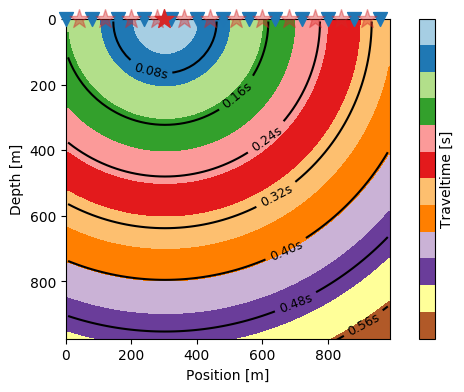

In [6]:
fig, ax = plt.subplots(figsize=(6,4))
cax = ax.imshow(trav[:,:,div(ns,3)], extent=[x[1], x[end], z[end], z[1]], aspect="equal", cmap="Paired",
    interpolation="bilinear", vmin=0, vmax=maximum(trav[:,:,div(ns,3)]))
cbar = fig.colorbar(cax, ax=ax)
cbar.ax.set(ylabel="Traveltime [s]")
cbar.ax.invert_yaxis() 
ax.scatter(src_x[1:4:end], src_z[1:4:end], color="#1f77b4", marker="v", s=100, clip_on=false, zorder=100)
ax.scatter(src_x[3:4:end], src_z[3:4:end], color="#d62728", alpha=0.4, marker="*", s=200, clip_on=false, zorder=100)
ax.scatter(src_x[div(ns,3)], src_z[div(ns,3)], color="#d62728", marker="*", s=200, clip_on=false, zorder=100)
con = ax.contour(trav[:,:,div(ns,3)], extent=[x[1], x[end], z[end], z[1]], origin="upper", colors="k")
plt.clabel(con, fontsize=9, inline=1, fmt="%1.2fs");
ax.set(xlabel="Position [m]", ylabel="Depth [m]", xlim=(x[1], x[end]), ylim=(z[end-1], z[1]))
fig.tight_layout()

### 3. Kirchhoff demigration (modeling)

`KirchMap` provides a simple to use interface around modeling and migration. The forward map performs modeling, and the adjoint performs migration. In simple terms, if `m` is the reflectivity model (in vector format) and `d` is the reflection response data, modeling is performed with

$$ Lm = d $$

and migration is performed with

$$ m_\text{mig} = L^\dagger d.$$

Both operations rely on two key pieces of information. The first is the time axis of the data. We will create a standard time axis of at most `2 s` sampling every `4 ms`. The second are the traveltime tables, which we have computed above.

Strictly speaking, the Kirchhoff operator does not contain the wavelet; thus to compute the full forward map $L$ we must first apply the Kirchhoff operator $G$ and then the convolution with the wavelet symbolized by operator $W$.

In [7]:
t = 0:0.008:1; nt = length(t)
G = KirchMig.KirchMap(t, trav);

┌ Warning: Using only one worker
└ @ KirchMig /home/cdacosta/Coding/julia/KirchMig.jl/src/map.jl:70


Once the operator is defined, Kirchhoff modeling is carried out like a simple matrix-vector multiplication.

In [8]:
@time Gm = G*refl[:]; # refl is 67×67 a array, refl[:] is a 4489-element vector

  1.744956 seconds (3.40 M allocations: 673.812 MiB, 10.96% gc time)


As per the theory, we also convolve the forward operator with the second time-derivative of the source wavelet:

In [9]:
ricker(t0, f) = @. (1 - 2pi^2 * f^2 * t0^2) * exp(-pi^2 * f^2 * t0^2)
rick_dtt = ricker(t .- t[div(nt,5)], 15);
@views rick_dtt[2:end-1] = (rick_dtt[1:end-2] - 2.0*rick_dtt[2:end-1] + rick_dtt[3:end])/(t[2] - t[1])^2;
rick_dtt /= maximum(abs.(rick_dtt));

W = KirchMig.ConvMap(rick_dtt, ns, ns, nt);

d = W*Gm;

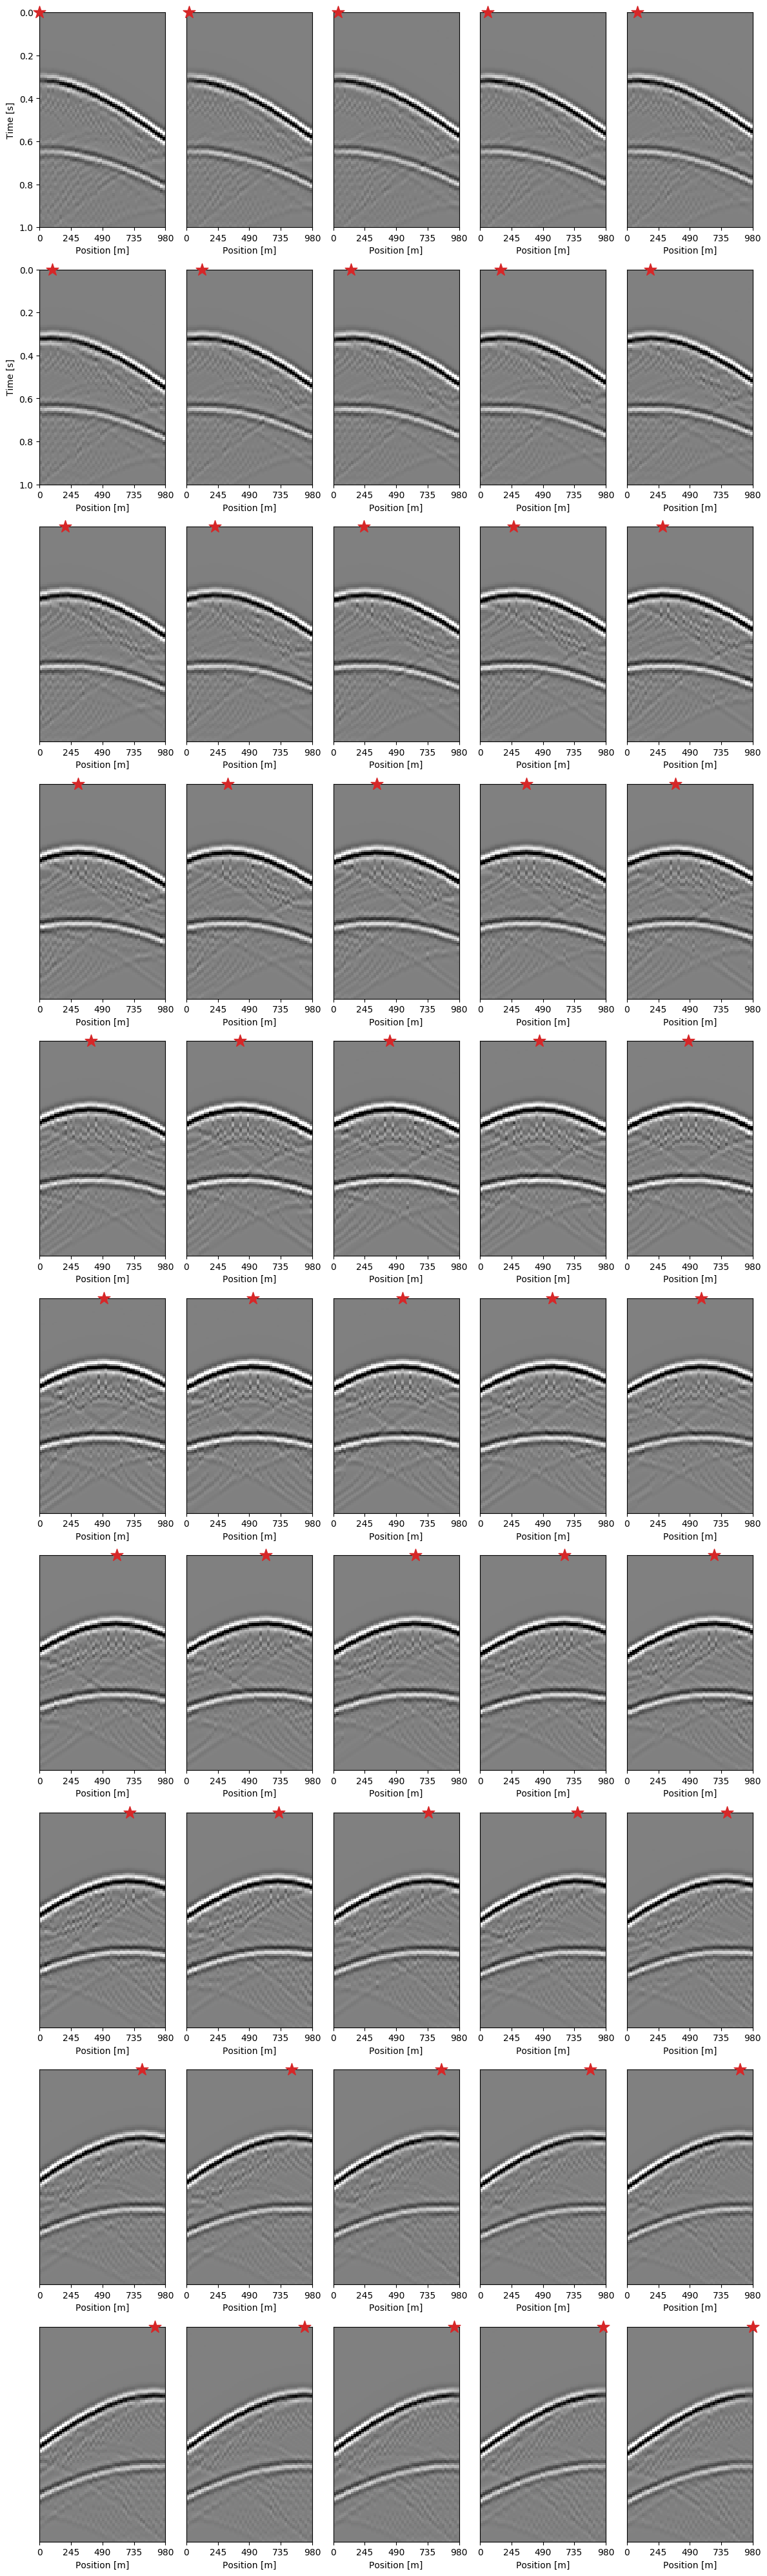

In [10]:
data = reshape(d, ns, ns, nt)

rows = 10
fig, ax = plt.subplots(rows, div(ns, rows), figsize=(12,4rows))
idx = reshape(1:rows*div(ns, rows), div(ns, rows), rows)'
for (i, axi) in enumerate(ax)
    csg = Array(data[:,idx[i],:]')
    cax = axi.imshow(csg, extent=[src_x[1], src_x[end], t[end], t[1]],
        vmin=-0.5maximum(abs.(csg)), vmax=0.5maximum(abs.(csg)), aspect="auto", cmap="gray", interpolation="none")
    axi.scatter(src_x[idx[i]], t[1], color="#d62728", marker="*", s=200, clip_on=false, zorder=100)
    axi.set(xlim=(src_x[1],src_x[end]), ylim=(t[end], t[1]), xlabel="Position [m]",
        xticks = range(minimum(src_x), stop=maximum(src_x), length=5))
    if idx[i] != 1 && idx[i] != div(ns,rows)+1
        axi.set(yticks=[])
    else
        axi.set(ylabel="Time [s]")
    end
end
fig.tight_layout()

### 4. Kirchhoff migration

Migration is simply the other side of the coin: it can be calculated by multiplication of the transpose $L$ by the data.

In [11]:
L = W*G
@time m_mig = L'd;

  1.378421 seconds (2.50 M allocations: 789.929 MiB, 6.49% gc time)


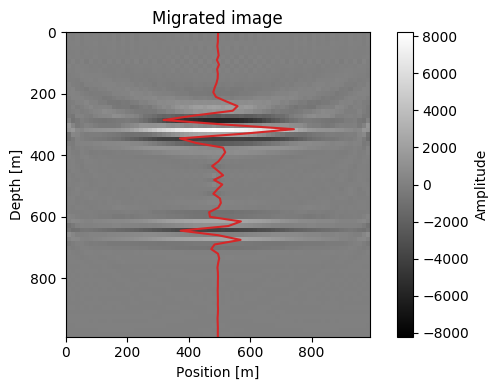

In [12]:
xran = x[end]-x[1]
mod_mig = reshape(m_mig, nz, nx)
vmin, vmax = maximum(abs.(mod_mig))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax.imshow(mod_mig, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
cbar = fig.colorbar(cax, ax=ax)
cbar.ax.set(ylabel="Amplitude");
ax.plot(xran*mod_mig[:,div(end,2)]./(4vmax) .+ xran./2, z, color="#d62728");
ax.set(xlim=(x[1], x[end]), ylim=(z[end], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="Migrated image")
fig.tight_layout()

### 5. Least-squares migration

If we apply the Kirchhoff migration operator to the forward equation, we obtain the following relationship

$$ L^\dagger Lm = L^\dagger d $$

where the right-hand side is equivalent to $m_\text{mig}$. Clearly, unless $L^\dagger L$ happens to be the identity, $m_\text{mig} \neq m$.

In least-squares migration, we attempt to invert $L^\dagger L$ and find the true inverse. Computing inverses directly, however, is seldom the best idea. First, the size of matrix $L^\dagger L$ is usually very large (in this case it is a meager 4489×4489). Second, the problem may be ill-posed, meaning that $L^\dagger L$ may lack an inverse. Instead we favor conditioned iterative methods of regularized problems, such as conjugate gradients. `KirchMig.jl` provides a very simple CG method, which here we will not precondition. We will see regularization in another example.


In [13]:
@time m_lsm, hist_m, hist_r = KirchMig.cg(L'L, m_mig, maxiter=15, log=true);

 16.759126 seconds (15.23 M allocations: 19.901 GiB, 13.09% gc time)


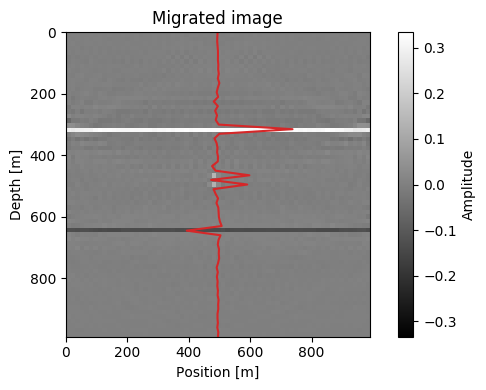

In [14]:
xran = x[end]-x[1]
mod_lsm = reshape(m_lsm, nz, nx)
vmin, vmax = maximum(abs.(mod_lsm))*[-1,1]
fig, ax = plt.subplots(figsize=(6,4))
cax = ax.imshow(mod_lsm, extent=[x[1], x[end], z[end], z[1]],
    vmin=vmin, vmax=vmax, aspect="equal", cmap="gray", interpolation=nothing)
cbar = fig.colorbar(cax, ax=ax)
cbar.ax.set(ylabel="Amplitude");
ax.plot(xran*mod_lsm[:,div(end,2)]./(4vmax) .+ xran./2, z, color="#d62728");
ax.set(xlim=(x[1], x[end]), ylim=(z[end], z[1]), xlabel="Position [m]", ylabel="Depth [m]",
    title="Migrated image")
fig.tight_layout()

In [15]:
import LinearAlgebra: norm
model_residuals = [ norm(m - refl[:])/norm(refl) for m in hist_m];

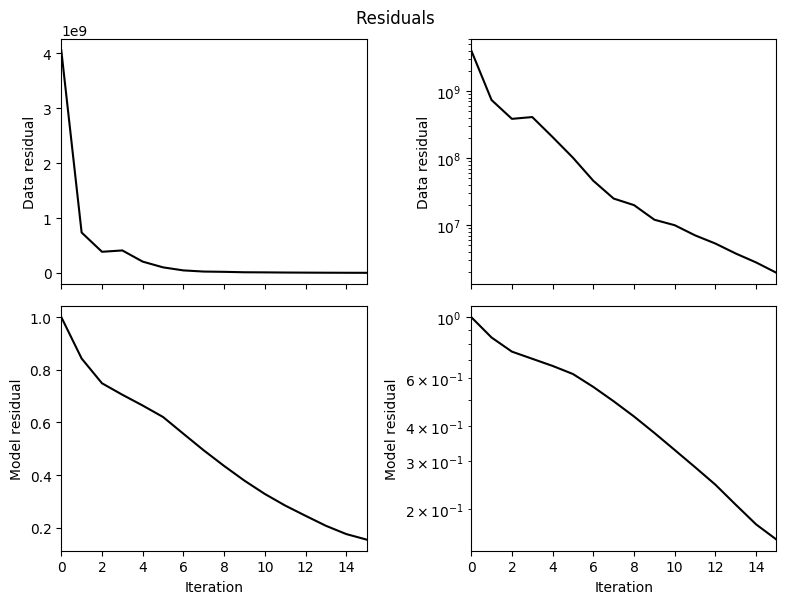

In [16]:
its = 0:(length(hist_r)-1)

fig, ax = plt.subplots(2, 2, figsize=(8,6), sharex=true)
ax[1].plot(its, hist_r, "k")
ax[1].set(ylabel="Data residual")
ax[3].semilogy(its, hist_r, "k")
ax[3].set(ylabel="Data residual")
ax[2].plot(its, model_residuals, "k")
ax[2].set(xlabel="Iteration", ylabel="Model residual")
ax[4].semilogy(its, model_residuals, "k")
ax[4].set(xlim=(its[1], its[end]), xlabel="Iteration", ylabel="Model residual")
ax[4].xaxis.set_major_locator(plt.matplotlib.ticker.MaxNLocator(integer=true))
fig.suptitle("Residuals", y=1.)
fig.tight_layout();

The image looks good, as well as the residuals. We can also visualize the (normalized) model-space errors:

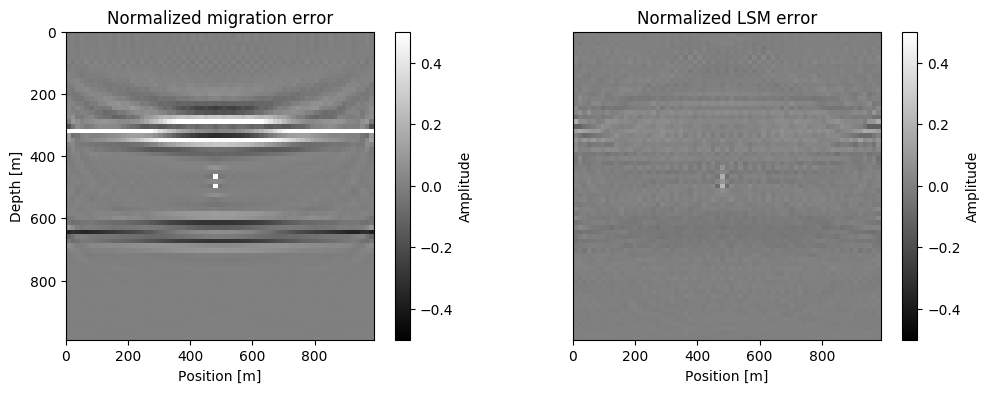

In [17]:
err_mig = refl/maximum(refl) - mod_mig/maximum(mod_mig)
err_lsm = refl/maximum(refl) - mod_lsm/maximum(mod_lsm)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
pclip=.5
cax = ax[1].imshow(err_mig, extent=[x[1], x[end], z[end], z[1]],
    vmin=-pclip, vmax=pclip, aspect="equal", cmap="gray", interpolation="none")
ax[1].set(xlabel="Position [m]", ylabel="Depth [m]", title="Normalized migration error")
cbar = fig.colorbar(cax, ax=ax[1])
cbar.ax.set(ylabel="Amplitude");

vmin, vmax = pclip*maximum(abs.(mod_lsm))*[-1,1]
cax = ax[2].imshow(err_lsm, extent=[x[1], x[end], z[end], z[1]],
    vmin=-pclip, vmax=pclip, aspect="equal", cmap="gray", interpolation="none")
ax[2].set(xlabel="Position [m]",title="Normalized LSM error", yticks=[]);
cbar = fig.colorbar(cax, ax=ax[2])
cbar.ax.set(ylabel="Amplitude");

Clearly LSM performs *much* better. Everywhere in the model has improved. We can also observe that standard migration has a systematic error which LSM lacks. Let us now take a vertical trace where standard migration has done the its best and worst, and show how the vertical resolution has also improved.

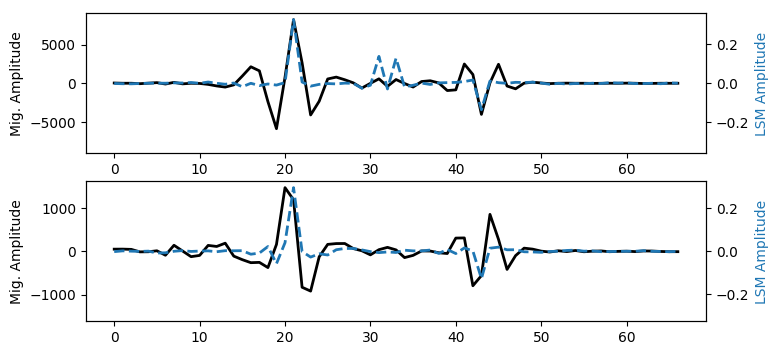

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(8,4))
ax[1].plot(mod_mig[:,div(end,2)], "k", linewidth=2)
ax[1].set(ylabel="Mig. Amplitude", ylim=[-1.1,1.1]*maximum(abs.(mod_mig[:,div(end,2)])))
ax2 = ax[1].twinx()
ax2.plot(mod_lsm[:,div(end,2)], "--", color="#1f77b4", linewidth=2)
ax2.set(ylim=[-1.1,1.1]*maximum(abs.(mod_lsm[:,div(end,2)])))
ax2.set_ylabel("LSM Amplitude", color="#1f77b4")

ax[2].plot(mod_mig[:,1], "k", linewidth=2)
ax[2].set(ylabel="Mig. Amplitude", ylim=[-1.1,1.1]*maximum(abs.(mod_mig[:,1])))
ax2 = ax[2].twinx()
ax2.plot(mod_lsm[:,1], "--", color="#1f77b4", linewidth=2)
ax2.set(ylim=[-1.1,1.1]*maximum(abs.(mod_lsm[:,1])))
ax2.set_ylabel("LSM Amplitude", color="#1f77b4");

Even where migration does a decent job, there is still an improvement in resolution and phase. Where standard migration is very poor, LSM has a very similar performance as when it does its best.